The final test data has been released. Several columns were taken out. Need to make sure:

- Data structure difference
- Whether current models still apply

# Training and Validation Data

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import itertools
import compose
%matplotlib inline

import sys
import os
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

import nzcompetition
from nzcompetition.preparation import make_prep_pipeline
from nzcompetition.plots import plot_train_pred, plot_pred_distribution

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [48]:
X_train, Y, X_val = nzcompetition.get_raw_data(target=['performance', 'odor'])

X_train, Y = nzcompetition.drop_dup(X_train, Y)
y_perf = Y['TOM Wash PT Model X']
y_odor = Y['TOM Odor PT Model X']

# Test Data

In [3]:
from libdl.dl import dl

In [6]:
dl.datasets.get(id='nz_kaggle').files.all()

['test_x', 'training', 'validation_x']

In [8]:
X_test = (
    dl.datasets.get(id='nz_kaggle')
    .files.get(id='test_x')
    .as_df()
    .set_index(["Organism Code", "purifiedsample_sequoia_identifier"])
)

In [11]:
[x.shape for x in [X_train, X_val, X_test]]

[(122, 114), (61, 114), (60, 108)]

There are 6 columns not in test set:

In [38]:
tomcols = list(set(X_train.columns).difference(set(X_test.columns)))
tomcols

['TOM Odor AT Model X',
 'TOM Odor AT Persil Universal Powder',
 'TOM Odor PT Persil Universal Powder',
 'TOM Wash PT Persil Universal Powder',
 'TOM Wash AT Persil Universal Powder',
 'TOM Wash AT Model X']

Check the missingness of those columns.

In [17]:
X_train[tomcols].isna().sum() / X_train.shape[0]

TOM Odor AT Model X                    0.442623
TOM Odor AT Persil Universal Powder    0.655738
TOM Odor PT Persil Universal Powder    0.663934
TOM Wash PT Persil Universal Powder    0.598361
TOM Wash AT Persil Universal Powder    0.696721
TOM Wash AT Model X                    0.000000
dtype: float64

Check the column order:

In [64]:
(X_train.drop(columns=tomcols).columns == X_test.columns).all()

True

Thus the column orders are identical, except for those TOM columns which are not in test set.

## Current preparation pipelines

Current preparation pipelines:
- For performance: 
    - TFF03N (with RandomForestRegressor, MSE in validation set 0.0094)
    - FFF03N (with AdaBoostRegressor, MSE in validation set 0.0119)
- For odor:
    - TTF03098 (with AdaBoostRegressor, MSE in validation set 0.3035)

The 4 "Persil" columns will be excluded, but the `TOM Odor AT Model X` and `TOM Wash AT Model X` are used by design. 

# Evaluate model after taking out `tomcols`

To determine whether to drop the columns and refit our models or treat the columns in test set as NA and use the current models, we need to evaluate the prediction if we fill the `TOM Odor AT Model X` and `TOM Wash AT Model X` by its mean in training set.

In [36]:
evaldf = pd.DataFrame(
    np.zeros((3, 4)), 
    index=pd.MultiIndex(
        levels = [
            ['perf', 'odor'],
            ['TFF03N_randfor', 'FFF03N_adaboost', 'TTF03098_adaboost']
        ], 
        codes = [
            [0, 0, 1],
            [0, 1, 2]
        ]
    ), 
    columns=pd.MultiIndex(
        levels = [
            ['training_set', 'validation_set'], 
            ['original_MSE', 'masked_MSE']
        ], 
        codes = [
            [0, 0, 1, 1], 
            [0, 1, 0, 1]
        ]
    )
)
# here 0.0 means lost of record
evaldf.loc[:, ('training_set', 'original_MSE')] = [0.0, 0.0142, 0.34298]
evaldf.loc[:, ('validation_set', 'original_MSE')] = [0.0094, 0.0119, 0.3035]
evaldf

training_set            validation_set           
                       original_MSE masked_MSE   original_MSE masked_MSE
perf TFF03N_randfor         0.00000        0.0         0.0094        0.0
     FFF03N_adaboost        0.01420        0.0         0.0119        0.0
odor TTF03098_adaboost      0.34298        0.0         0.3035        0.0

In [41]:
# prep pipeline
prep_pipe_TFF03N = make_prep_pipeline(True, False, False, 0.3)
prep_pipe_FFF03N = make_prep_pipeline(False, False, False, 0.3)
prep_pipe_TTF03098 = Pipeline([
    ('prep', make_prep_pipeline(True, True, False, 0.3)), 
    ('pca', PCA(0.98))
])

In [43]:
# fit preparation pipeline
X_train_TFF03N = prep_pipe_TFF03N.fit_transform(X_train)
X_train_FFF03N = prep_pipe_FFF03N.fit_transform(X_train)
X_train_TTF03098 = prep_pipe_TTF03098.fit_transform(X_train)

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


In [39]:
# mask data
def mask_tom(df):
    newdf = df.copy()
    newdf[tomcols] = np.nan
    return newdf

X_train_masked = mask_tom(X_train)
X_val_masked = mask_tom(X_val)

In [51]:
X_train_masked_TFF03N = prep_pipe_TFF03N.transform(X_train_masked)
X_train_masked_FFF03N = prep_pipe_FFF03N.transform(X_train_masked)
X_train_masked_TTF03098 = prep_pipe_TTF03098.transform(X_train_masked)

X_val_masked_TFF03N = prep_pipe_TFF03N.transform(X_val_masked)
X_val_masked_FFF03N = prep_pipe_FFF03N.transform(X_val_masked)
X_val_masked_TTF03098 = prep_pipe_TTF03098.transform(X_val_masked)


/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)
/nfs/home/shya

In [55]:
# check shape
[x.shape for x in [
    X_train_masked_TFF03N,
    X_train_masked_FFF03N,
    X_train_masked_TTF03098,
    X_val_masked_TFF03N,
    X_val_masked_FFF03N,
    X_val_masked_TTF03098,
]]

[(122, 72), (122, 69), (122, 32), (61, 72), (61, 69), (61, 32)]

In [26]:
# prediction models
perf_TFF03N_randfor = joblib.load('../models/performance_TFF03N_randfor.pkl')
perf_FFF03N_adaboost = joblib.load('../models/performance_FFF03N_adaboost.pkl')
odor_TTF03098_adaboost = joblib.load('../models/odor_TTF03098_adaboost.pkl')

In [49]:
evaldf.loc[('perf', 'TFF03N_randfor'), ('training_set', 'original_MSE')] = (
    mean_squared_error(y_perf, perf_TFF03N_randfor.predict(X_train_TFF03N))
)

In [52]:
evaldf.loc[:, ('training_set', 'masked_MSE')] = [
    mean_squared_error(y_perf, perf_TFF03N_randfor.predict(X_train_masked_TFF03N)), 
    mean_squared_error(y_perf, perf_FFF03N_adaboost.predict(X_train_masked_FFF03N)),
    mean_squared_error(y_odor, odor_TTF03098_adaboost.predict(X_train_masked_TTF03098))
]

Now let's make prediction on validation set and check the result.

In [59]:
pd.DataFrame(
    perf_TFF03N_randfor.predict(X_val_masked_TFF03N), 
    index=X_val.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/masked_validation/perf_TFF03N_randfor.csv')

pd.DataFrame(
    perf_FFF03N_adaboost.predict(X_val_masked_FFF03N), 
    index=X_val.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/masked_validation/perf_FFF03N_adaboost.csv')

pd.DataFrame(
    odor_TTF03098_adaboost.predict(X_val_masked_TTF03098), 
    index=X_val.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/masked_validation/odor_TTF03098_adaboost.csv')

In [60]:
evaldf.loc[:, ('validation_set', 'masked_MSE')] = [0.0691, 0.0666, 0.3134]

In [61]:
evaldf

training_set            validation_set           
                       original_MSE masked_MSE   original_MSE masked_MSE
perf TFF03N_randfor        0.006951   0.069839         0.0094     0.0691
     FFF03N_adaboost       0.014200   0.065125         0.0119     0.0666
odor TTF03098_adaboost     0.342980   0.182901         0.3035     0.3134

From the table above we know that the odor model is not much affected but the performance models will not work. We'd better refit them.

---

# Test Ground

In [65]:
perf_TFF03N_randfor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [66]:
perf_FFF03N_adaboost

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=5,
                                                       max_features=0.7550778086449602,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=8,
                                                       min_samples_split=5,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.6261716502824434, loss='linear',
              

In [67]:
odor_TTF03098_adaboost

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=5,
                                                       max_features=0.870076057438373,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=8,
                                                       min_samples_split=10,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.6761997350188298, loss='linear',
              

In [1]:
from scipy.stats import (
    randint, 
    expon, 
    reciprocal, 
    uniform, 
    norm
)

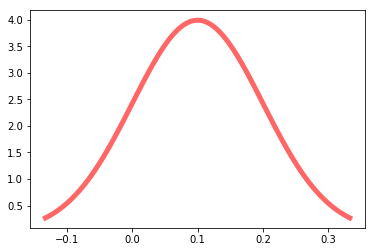

In [5]:
dist = norm(0.1, 0.1)
x = np.linspace(dist.ppf(0.01),
                dist.ppf(0.99), 100)
plt.plot(x, dist.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')